# Predicción de resultados de Fútbol
## Análisis de Rendimiento y Modelo Predictivo
**Objetivo:** Desarrollar un modelo que permita predecir el resultado de un partido (Victoria / Empate / Derrota) y analizar los factores clave que influyen en el rendimiento de un equipo, basándose en estadísticas históricas.

**Dataset:** European Soccer Database (https://www.kaggle.com/datasets/hugomathien/soccer)

### Importar librerias esenciales

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib as Path

### Conexión a la Base de Datos

In [3]:
DATABASE_PATH = Path.Path("database.sqlite")
#Vericar que el archivo existe
if not DATABASE_PATH.exists():
    raise FileNotFoundError(f"Database file not found at {DATABASE_PATH}")

# Conectar a la base de datos SQLite
conn = sqlite3.connect(DATABASE_PATH)

# Visualizar las tablas disponibles
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"

tables = pd.read_sql_query(tables_query, conn)
print("Tablas disponibles en la base de datos:")
display(tables)

Tablas disponibles en la base de datos:


,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


Para cumplir con nuestro objetivo de predecir **Victoria**/**Empate**/**Derrota** las tablas **Match**,**Team** y **League** son suficientes para ello, pero ¿porque?.

Pues porque las tabla

**Match:** ya contiene los resultados y muchas estadísticas de rendimiento.

**Team** y **League** me permiten enriquecer el contexto y unir nombres para análisis y visualización.

### Carga y Unión de Datos 

In [4]:
# Carga de datos principales
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_country = pd.read_sql_query("SELECT * FROM Country", conn)

#Vista rápida de los datos
print("Información de los equipos:")
display(df_team.head())
print("Información de las ligas:")
display(df_league.head())
print("Información de los partidos:")
display(df_match.head())
print("Información de los países:")
display(df_country)

Información de los equipos:


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


Información de las ligas:


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


Información de los partidos:


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


Información de los países:


,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [5]:
# Unir información de los partidos con los equipos y ligas
df_country = df_country.rename(columns={'id': 'country_id'})

df = df_match \
    .merge(df_team[['team_api_id', 'team_long_name']], left_on='home_team_api_id', right_on='team_api_id', how='left') \
    .rename(columns={'team_long_name': 'home_team'}) \
    .drop('team_api_id', axis=1) \
    .merge(df_team[['team_api_id', 'team_long_name']], left_on='away_team_api_id', right_on='team_api_id', how='left') \
    .rename(columns={'team_long_name': 'away_team'}) \
    .drop('team_api_id', axis=1) \
    .merge(df_league[['id', 'name']], left_on='league_id', right_on='id', how='left') \
    .rename(columns={'name': 'league_name'}) \
    .drop('id', axis=1, errors='ignore') \
    .merge(df_country[['country_id', 'name']], left_on='country_id', right_on='country_id', how='left') \
    .rename(columns={'country_id': 'country_name'}) \
    .drop('country_id', axis=1, errors='ignore')

display(df.shape)


# Equipos locales sin nombre
print(f"Equipos locales sin nombre: {df['home_team'].isnull().sum()}")
# Equipos visitantes sin nombre
print(f"Equipos visitantes sin nombre: {df['away_team'].isnull().sum()}")
# Ligas sin nombre
print(f"Ligas sin nombre: {df['league_name'].isnull().sum()}")

# Ver ejemplos de datos
print(f"\nEjemplos de partidos:")
print(df[['date', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal', 
          'league_name', 'country_name']].head(10))


    

(25979, 120)

Equipos locales sin nombre: 0
Equipos visitantes sin nombre: 0
Ligas sin nombre: 0

Ejemplos de partidos:
                  date          home_team             away_team  \
0  2008-08-17 00:00:00           KRC Genk          Beerschot AC   
1  2008-08-16 00:00:00   SV Zulte-Waregem      Sporting Lokeren   
2  2008-08-16 00:00:00  KSV Cercle Brugge        RSC Anderlecht   
3  2008-08-17 00:00:00           KAA Gent             RAEC Mons   
4  2008-08-16 00:00:00      FCV Dender EH     Standard de Liège   
5  2008-09-24 00:00:00        KV Mechelen        Club Brugge KV   
6  2008-08-16 00:00:00      KSV Roeselare           KV Kortrijk   
7  2008-08-16 00:00:00             Tubize  Royal Excel Mouscron   
8  2008-08-16 00:00:00       KVC Westerlo    Sporting Charleroi   
9  2008-11-01 00:00:00     Club Brugge KV           KV Kortrijk   

   home_team_goal  away_team_goal             league_name  country_name  
0               1               1  Belgium Jupiler League             1  
1       

### Análisis Exploratorio de Datos (EDA)
Pasos:

1. Crear una variable objetivo 

2. Analizar valores nulos y decidir que hacer 

3. Explorar distribuciones 



 Distribución de resultados:
Victoria: 11917 (0.46%)
Derrota: 7466 (0.29%)
Empate: 6596 (0.25%)


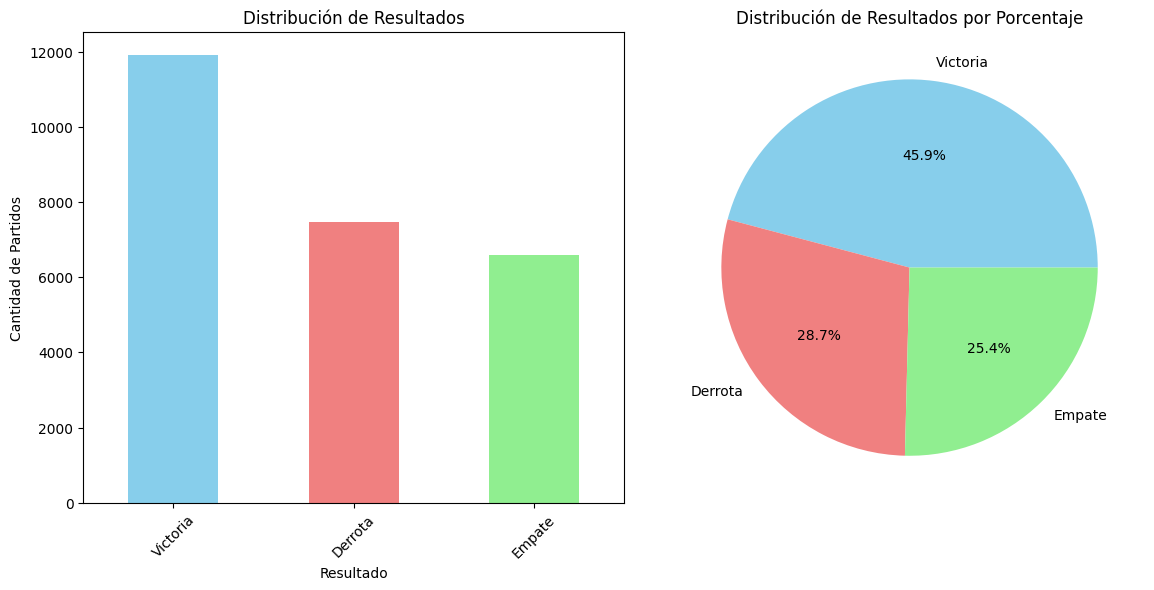

In [6]:
# Crear variable objetivo

df["result"] = df.apply(lambda row: "Victoria" if row["home_team_goal"] > row["away_team_goal"] else
                        ("Derrota" if row["home_team_goal"] < row["away_team_goal"] else "Empate"), axis=1)

# Analisis de la variable objetivo
result_counts = df['result'].value_counts()
result_pct = df['result'].value_counts(normalize=True)

print("\n Distribución de resultados:")
for result in result_counts.index:
    print(f"{result}: {result_counts[result]} ({result_pct[result]:.2f}%)")

# Visualización de la variable objetivo

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de barras

result_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_title('Distribución de Resultados')
ax1.set_xlabel('Resultado')
ax1.set_ylabel('Cantidad de Partidos')
ax1.tick_params(axis='x', rotation=45)

# Gráfico de torta

ax2.pie(result_counts.values, labels=result_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_title('Distribución de Resultados por Porcentaje')
plt.tight_layout()
plt.show()
                       


Columnas con valores nulos:


0.859504132231405

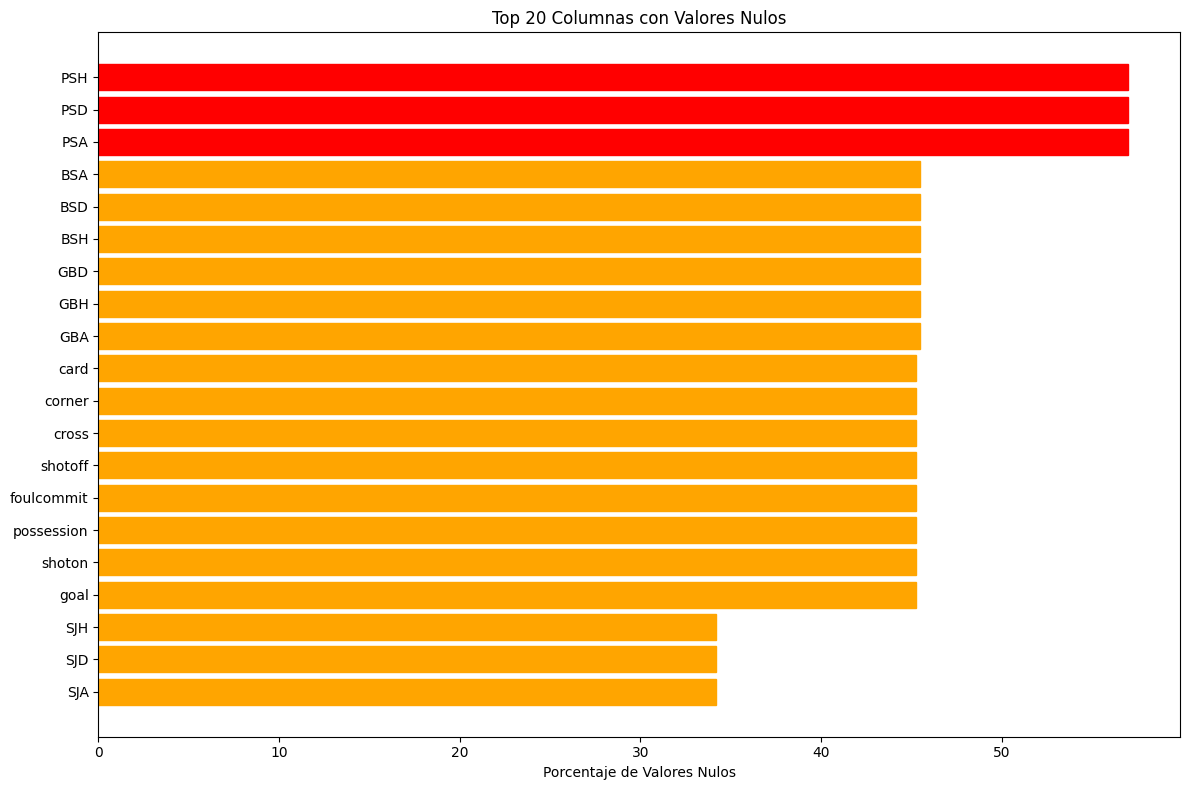

In [11]:
# Analisis de valores nulos

null_counts = df.isnull().sum()
null_porcentages = (null_counts / len(df)) * 100

#Crear DataFrame para los valores nulos
null_df = pd.DataFrame({
    'Column': df.columns,
    'Null_count': null_counts.values,
    'Null_Porcentage' : null_porcentages.values
}).sort_values(by='Null_Porcentage', ascending=False)

# Mostrar columna con valores nulos

null_columns = null_df[null_df['Null_Porcentage'] > 0]
print("\nColumnas con valores nulos:")
display(len(null_columns) / len(df.columns))

# Visualizar los valores nulos
if len(null_columns) > 0:
    plt.figure(figsize=(12, 8))
    top_null = null_columns.head(20)

    bars = plt.barh(range(len(top_null)), top_null['Null_Porcentage'])
    plt.yticks(range(len(top_null)), top_null['Column'])
    plt.xlabel('Porcentaje de Valores Nulos')
    plt.title('Top 20 Columnas con Valores Nulos')
    plt.gca().invert_yaxis()

    # Colorear barras según el porcentaje de nulos
    for i, bar in enumerate(bars):
        if top_null.iloc[i]['Null_Porcentage'] > 50:
            bar.set_color('red')
        elif top_null.iloc[i]['Null_Porcentage'] > 20:
            bar.set_color('orange')
        else:
            bar.set_color('green')
    
    plt.tight_layout()
    plt.show()

In [15]:
# Verificar que representan exactamente PSH, PSD y PSA en mi dataset

print("Estadísticas decriptivas de PSH, PSD y PSA:")

column = ["PSH", "PSD", "PSA"]
for col in column:
    if col in df.columns:
        print(f"Columna: {col}")
        print(f"Valores únicos: {df[col].nunique()}")
        print(f"Rango de valores: {df[col].min():.2f} - {df[col].max():.2f}")
        print(f"Media: {df[col].mean():.2f}")
        print(f"Valores nulos: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.1f}%)")
        print("------------------------------")
        #print(df[col].describe())
    else:
        print(f"\n{col} no está presente en el DataFrame.")

Estadísticas decriptivas de PSH, PSD y PSA:
Columna: PSH
Valores únicos: 948
Rango de valores: 1.04 - 36.00
Media: 2.82
Valores nulos: 14811 (57.0%)
------------------------------
Columna: PSD
Valores únicos: 665
Rango de valores: 2.20 - 29.00
Media: 4.13
Valores nulos: 14811 (57.0%)
------------------------------
Columna: PSA
Valores únicos: 1475
Rango de valores: 1.09 - 47.50
Media: 4.97
Valores nulos: 14811 (57.0%)
------------------------------


Eliminar las columnas:
 1. **PSA** 
 2. **PSH** 
 3. **PSD** 

Con más del 55% de datos faltantes, cualquier imputación será más una especulación que dato real.

Entonces, se eliminan las variables PSH, PSD y PSA por contener más del 55% de valores nulos y carecer de una estrategia confiable de imputación sin introducir sesgos especulativos.